In [1]:
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from tsfresh import extract_features
from tsfresh.feature_extraction.feature_calculators import set_property
import pycatch22

from sklearn.model_selection import train_test_split

import pandas as pd
from tqdm import tqdm
import os
import random
import json


## 0. some functions

In [2]:
def collect_data(task_names, class_num, detailed_class2class):
    """
    collect data from raw json data and save them into csv files
    """
    data_root = os.path.join('data', 'ode_raw_data')
    for task_name in tqdm(task_names):
        task_data_root = os.path.join(data_root, task_name)
        save_root = os.path.join('data', f'{str(class_num)}_class', 'raw')
        if not os.path.exists(save_root):
            os.makedirs(save_root)

        class_name = detailed_class2class[task_name]
        new_class_data_path = os.path.join(save_root, f'{class_name}__all.csv')
        if os.path.exists(new_class_data_path):
            df_new_class = pd.read_csv(new_class_data_path)
        else:
            df_new_class = pd.DataFrame()

        data_column = ['id']
        for i in range(30):
            data_column += [f's{i}']
        for i in range(30):
            data_column += [f'p{i}']
        data = pd.DataFrame(columns=data_column)

        for file in os.listdir(task_data_root):
            if file.endswith('.json'):
                with open(os.path.join(task_data_root, file), 'r') as f:
                    task_data = json.load(f)
                
                id = f'{class_name}-{task_name}-{file[:-5]}'
                data.loc[data.shape[0]] = [id] + task_data['s'] + task_data['p']

        data_noDup = data.drop_duplicates('id')
        assert data_noDup.shape[0] == data.shape[0]
        print(f'{task_name} has {data.shape[0]} samples')

        df_new_class = pd.concat([df_new_class, data], ignore_index=True)
        df_new_class.to_csv(new_class_data_path, index=False)


# add error to data
def add_error(data:pd.DataFrame, random_seed=42, ignore_cols=['id', 'class', 'label', 'old_class', 'cat_conc']):
    """
    add 0%, 0.5%, 1% or 2% gaussian noise to data
    """
    error_list = [0, 0.5, 1, 2]
    data_ = data.copy()
    for col in ignore_cols:
        if col in data_.columns:
            data_ = data_.drop(columns=[col])
    random.seed(random_seed)
    for i in range(len(data_)):
        error = random.choice(error_list)
        # print(error)
        data_.loc[i] += [random.gauss(0, error / 100) for i in range(data_.shape[1])]
    for col in ignore_cols:
        if col in data.columns:
            data_[col] = data[col]
    # rearrange columns
    cols = data.columns.tolist()
    data_ = data_[cols]
    return data_


# add catch22 features into tsfresh
@set_property("fctype", "combiner")
def catch22(x, param):
    """
    pycatch22, a Python library that wraps the CATCH time series characteristics

    Lubba et al. catch22: CAnonical Time-series CHaracteristics, Data Min Knowl Disc 33, 1821 (2019).

    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :return: list of tuples (s, f) where s are the feature name in catch22, serialized as a string,
             and f the respective feature value as bool, int or float
    :return type: pandas.Series
    """
    data = pycatch22.catch22_all(x)

    return [(name, value) for name, value in zip(data['names'], data['values'])]

settings = ComprehensiveFCParameters()
settings[catch22] = None

## 1. prepare data for 5 classes
- collect data from ode raw data(json)
- add gaussian noise to the data
- split the data into train and test set
- extract tsfresh features from the data and save them

In [3]:
class_num = 5

detailed_class_list = [
    '1__single', 
    '1__double',
    '1__double_outside',
    '1__double_inside',
    '0__single',
    '0__double',
    '0__double_outside',
    '0__double_inside',
    'mm__single',
    # 'mm__single_outside',
    'mm__double',
    'mm__double_outside',
    'mm__double_inside',
]

detailed_class_short_list = [
    '1_sgl', 
    '1_dbl',
    '1_dbl_out',
    '1_dbl_in',
    '0_sgl',
    '0_dbl',
    '0_dbl_out',
    '0_dbl_in',
    'mm_sgl',
    # 'mm_sgl_out',
    'mm_dbl',
    'mm_dbl_out',
    'mm_dbl_in',
]

detailed_class2class = {
    '1__single': 'first', 
    '1__double': 'second',
    '1__double_outside': 'second',
    '1__double_inside': 'second',
    '0__single': 'zero',
    '0__double': 'first',
    '0__double_outside': 'first',
    '0__double_inside': 'first',
    'mm__single': 'mm_1',
    # 'mm__single_outside': 'mm_1_out',
    'mm__double': 'mm_2',
    'mm__double_outside': 'mm_2',
    'mm__double_inside': 'mm_2',
}

class_list = [
    'zero',
    'first',
    'second',
    'mm_1',
    # 'mm_1_out',
    'mm_2',
]

In [4]:
collect_data(
    task_names=detailed_class_list, 
    class_num=class_num,
    detailed_class2class=detailed_class2class
)

  8%|▊         | 1/12 [00:22<04:09, 22.65s/it]

1__single has 11404 samples


 17%|█▋        | 2/12 [00:44<03:42, 22.28s/it]

1__double has 10710 samples
1__double_outside has 11156 samples


 25%|██▌       | 3/12 [01:06<03:17, 21.96s/it]

1__double_inside has 13332 samples


 33%|███▎      | 4/12 [01:34<03:14, 24.32s/it]

0__single has 13671 samples


 42%|████▏     | 5/12 [01:59<02:53, 24.72s/it]

0__double has 12214 samples


 50%|█████     | 6/12 [02:21<02:23, 23.89s/it]

0__double_outside has 20369 samples


 58%|█████▊    | 7/12 [03:06<02:33, 30.63s/it]

0__double_inside has 12902 samples


 75%|███████▌  | 9/12 [03:49<01:16, 25.56s/it]

mm__single has 10742 samples


 83%|████████▎ | 10/12 [04:08<00:46, 23.40s/it]

mm__double has 10728 samples
mm__double_outside has 10772 samples


 92%|█████████▏| 11/12 [04:27<00:22, 22.04s/it]

mm__double_inside has 11022 samples


100%|██████████| 12/12 [04:46<00:00, 23.91s/it]


In [5]:

data_size_for_tasks = {
    # zero
    '0__single': 10000,

    # mm_1
    'mm__single': 10000,

    # mm_1_out
    # 'mm__single_outside': 10000,

    # first
    '1__single': 3220, 
    '0__double': 3220,
    '0__double_outside': 3220,
    '0__double_inside': 340,

    # mm_2
    'mm__double': 3334,
    'mm__double_outside': 3333,
    'mm__double_inside': 3333,
    
    # second
    '1__double': 3334,
    '1__double_outside': 3333,
    '1__double_inside': 3333,
}
random_seed = 29
for class_name in tqdm(class_list):
    data_path = os.path.join('data', f'{str(class_num)}_class', 'raw', f'{class_name}__all.csv')
    data = pd.read_csv(data_path)
    data['old_class'] = data['id'].apply(lambda x: x.split('-')[1])
    sampled_data = pd.DataFrame()
    for old_class in data['old_class'].unique().tolist():
        print(old_class)
        data_ = data[data['old_class'] == old_class].sample(n=data_size_for_tasks[old_class], random_state=random_seed)
        sampled_data = pd.concat([sampled_data, data_], ignore_index=True)
    print(class_name)
    print(sampled_data.shape)
    print(sampled_data.drop_duplicates('id').shape)
    sampled_data.to_csv(os.path.join('data', f'{str(class_num)}_class', 'raw', f'{class_name}__10k.csv'), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

0__single
zero
(10000, 62)
(10000, 62)


 20%|██        | 1/5 [00:00<00:01,  2.29it/s]

1__single
0__double
0__double_outside
0__double_inside
first
(10000, 62)
(10000, 62)


 40%|████      | 2/5 [00:01<00:01,  1.75it/s]

1__double
1__double_outside
1__double_inside
second
(10000, 62)
(10000, 62)


 60%|██████    | 3/5 [00:01<00:01,  1.84it/s]

mm__single
mm_1
(10000, 62)
(10000, 62)


 80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

mm__double
mm__double_outside
mm__double_inside
mm_2
(10000, 62)
(10000, 62)


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


In [6]:
# concat data, add error and split train_val test
data_root = os.path.join(f'data', f'{str(class_num)}_class', 'raw')
data = pd.DataFrame()
for task_name in tqdm(class_list):
    data_path = os.path.join(data_root, f'{task_name}__10k.csv')
    data_tmp = pd.read_csv(data_path)
    data_tmp['class'] = task_name
    data = pd.concat([data, data_tmp], axis=0, ignore_index=True)
data = add_error(data)
print('first:', data[data['class'] == 'first'].shape)
print('second:', data[data['class'] == 'second'].shape)
print('zero:', data[data['class'] == 'zero'].shape)
print('mm_1:', data[data['class'] == 'mm_1'].shape)
# print('mm_1_out:', data[data['class'] == 'mm_1_out'].shape)
print('mm_2:', data[data['class'] == 'mm_2'].shape)

train_val_data, test_data = train_test_split(data, test_size=0.1, random_state=random_seed, stratify=data['class'])
train_val_data.to_csv(os.path.join('data', f'{str(class_num)}_class', 'train_val.csv'), index=False)
test_data.to_csv(os.path.join('data', f'{str(class_num)}_class', 'test.csv'), index=False)

100%|██████████| 5/5 [00:00<00:00, 19.37it/s]


first: (10000, 63)
second: (10000, 63)
zero: (10000, 63)
mm_1: (10000, 63)
mm_2: (10000, 63)


In [7]:
data_root = os.path.join('data', f'{str(class_num)}_class')
for set_ in ['train_val', 'test']:
    data_path = os.path.join(data_root, f'{set_}.csv')
    data = pd.read_csv(data_path)
    data.drop(columns=['old_class'], inplace=True)
    
    # fit dataset format for tsfresh
    data_tsfresh = pd.DataFrame(columns=['id', 't', 's', 'p'])
    data_tsfresh_ids = []
    data_tsfresh_ts = []
    data_tsfresh_ss = []
    data_tsfresh_ps = []
    for i in tqdm(range(data.shape[0]), desc=set_):
        id = data.loc[i, 'id']
        for j in range(30):
            data_tsfresh_ss.append(data.loc[i, f's{j}'])
            data_tsfresh_ps.append(data.loc[i, f'p{j}'])
        data_tsfresh_ids += [id] * 30
        data_tsfresh_ts += list(range(30))
    data_tsfresh['id'] = data_tsfresh_ids
    data_tsfresh['t'] = data_tsfresh_ts
    data_tsfresh['s'] = data_tsfresh_ss
    data_tsfresh['p'] = data_tsfresh_ps

    # extract tsfresh features
    data_feat = extract_features(data_tsfresh, column_id='id', column_sort='t', default_fc_parameters=settings)
    data_feat['id'] = data_feat.index
    data_feat['class'] = data_feat['id'].apply(lambda x: x.split('-')[0])
    data_feat.to_csv(os.path.join(data_root, f'{set_}_tsfresh_feat.csv'), index=False)

Feature Extraction: 100%|██████████| 60/60 [00:30<00:00,  1.97it/s]


## 2. prepare data for 6 classes
- collect data from ode raw data(json)
- add gaussian noise to the data
- split the data into train and test set
- extract tsfresh features from the data and save them

In [8]:
class_num = 6

detailed_class_list = [
    '1__single', 
    '1__double',
    '1__double_outside',
    '1__double_inside',
    '0__single',
    '0__double',
    '0__double_outside',
    '0__double_inside',
    'mm__single',
    'mm__single_outside',
    'mm__double',
    'mm__double_outside',
    'mm__double_inside',
]

detailed_class_short_list = [
    '1_sgl', 
    '1_dbl',
    '1_dbl_out',
    '1_dbl_in',
    '0_sgl',
    '0_dbl',
    '0_dbl_out',
    '0_dbl_in',
    'mm_sgl',
    'mm_sgl_out',
    'mm_dbl',
    'mm_dbl_out',
    'mm_dbl_in',
]

detailed_class2class = {
    '1__single': 'first', 
    '1__double': 'second',
    '1__double_outside': 'second',
    '1__double_inside': 'second',
    '0__single': 'zero',
    '0__double': 'first',
    '0__double_outside': 'first',
    '0__double_inside': 'first',
    'mm__single': 'mm_1',
    'mm__single_outside': 'mm_1_out',
    'mm__double': 'mm_2',
    'mm__double_outside': 'mm_2',
    'mm__double_inside': 'mm_2',
}

class_list = [
    'zero',
    'first',
    'second',
    'mm_1',
    'mm_1_out',
    'mm_2',
]

In [9]:
collect_data(
    task_names=detailed_class_list, 
    class_num=class_num,
    detailed_class2class=detailed_class2class
)

  0%|          | 0/13 [00:00<?, ?it/s]

1__single has 11404 samples


  8%|▊         | 1/13 [00:35<07:04, 35.41s/it]

1__double has 10710 samples


 15%|█▌        | 2/13 [01:12<06:37, 36.16s/it]

1__double_outside has 11156 samples


 23%|██▎       | 3/13 [01:55<06:36, 39.67s/it]

1__double_inside has 13332 samples


 31%|███       | 4/13 [02:44<06:30, 43.35s/it]

0__single has 13671 samples


 38%|███▊      | 5/13 [03:11<04:59, 37.44s/it]

0__double has 12214 samples


 46%|████▌     | 6/13 [03:31<03:40, 31.53s/it]

0__double_outside has 20369 samples


 54%|█████▍    | 7/13 [04:17<03:35, 35.99s/it]

0__double_inside has 12902 samples


 69%|██████▉   | 9/13 [05:03<01:55, 28.90s/it]

mm__single has 10742 samples
mm__single_outside has 19319 samples


 85%|████████▍ | 11/13 [06:08<00:58, 29.50s/it]

mm__double has 10728 samples
mm__double_outside has 10772 samples


 92%|█████████▏| 12/13 [06:28<00:26, 26.60s/it]

mm__double_inside has 11022 samples


100%|██████████| 13/13 [06:48<00:00, 31.42s/it]


In [10]:
data_size_for_tasks = {
    # zero
    '0__single': 10000,

    # mm_1
    'mm__single': 10000,

    # mm_1_out
    'mm__single_outside': 10000,

    # first
    '1__single': 3220, 
    '0__double': 3220,
    '0__double_outside': 3220,
    '0__double_inside': 340,

    # mm_2
    'mm__double': 3334,
    'mm__double_outside': 3333,
    'mm__double_inside': 3333,
    
    # second
    '1__double': 3334,
    '1__double_outside': 3333,
    '1__double_inside': 3333,
}
random_seed = 29
for class_name in tqdm(class_list):
    data_path = os.path.join('data', f'{str(class_num)}_class', 'raw', f'{class_name}__all.csv')
    data = pd.read_csv(data_path)
    data['old_class'] = data['id'].apply(lambda x: x.split('-')[1])
    sampled_data = pd.DataFrame()
    for old_class in data['old_class'].unique().tolist():
        print(old_class)
        data_ = data[data['old_class'] == old_class].sample(n=data_size_for_tasks[old_class], random_state=random_seed)
        sampled_data = pd.concat([sampled_data, data_], ignore_index=True)
    print(class_name)
    print(sampled_data.shape)
    print(sampled_data.drop_duplicates('id').shape)
    sampled_data.to_csv(os.path.join('data', f'{str(class_num)}_class', 'raw', f'{class_name}__10k.csv'), index=False)

 17%|█▋        | 1/6 [00:00<00:01,  4.58it/s]

0__single
zero
(10000, 62)
(10000, 62)
1__single
0__double
0__double_outside
0__double_inside
first
(10000, 62)
(10000, 62)


 50%|█████     | 3/6 [00:00<00:00,  3.28it/s]

1__double
1__double_outside
1__double_inside
second
(10000, 62)
(10000, 62)


 67%|██████▋   | 4/6 [00:01<00:00,  3.78it/s]

mm__single
mm_1
(10000, 62)
(10000, 62)


 83%|████████▎ | 5/6 [00:01<00:00,  3.98it/s]

mm__single_outside
mm_1_out
(10000, 62)
(10000, 62)


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

mm__double
mm__double_outside
mm__double_inside
mm_2
(10000, 62)
(10000, 62)


In [11]:
# concat data, add error and split train_val test
data_root = os.path.join(f'data', f'{str(class_num)}_class', 'raw')
data = pd.DataFrame()
for task_name in tqdm(class_list):
    data_path = os.path.join(data_root, f'{task_name}__10k.csv')
    data_tmp = pd.read_csv(data_path)
    data_tmp['class'] = task_name
    data = pd.concat([data, data_tmp], axis=0, ignore_index=True)
data = add_error(data)
print('first:', data[data['class'] == 'first'].shape)
print('second:', data[data['class'] == 'second'].shape)
print('zero:', data[data['class'] == 'zero'].shape)
print('mm_1:', data[data['class'] == 'mm_1'].shape)
print('mm_1_out:', data[data['class'] == 'mm_1_out'].shape)
print('mm_2:', data[data['class'] == 'mm_2'].shape)

train_val_data, test_data = train_test_split(data, test_size=0.1, random_state=random_seed, stratify=data['class'])
train_val_data.to_csv(os.path.join('data', f'{str(class_num)}_class', 'train_val.csv'), index=False)
test_data.to_csv(os.path.join('data', f'{str(class_num)}_class', 'test.csv'), index=False)

100%|██████████| 6/6 [00:00<00:00, 33.26it/s]


first: (10000, 63)
second: (10000, 63)
zero: (10000, 63)
mm_1: (10000, 63)
mm_1_out: (10000, 63)
mm_2: (10000, 63)


In [12]:
data_root = os.path.join('data', f'{str(class_num)}_class')
for set_ in ['train_val', 'test']:
    data_path = os.path.join(data_root, f'{set_}.csv')
    data = pd.read_csv(data_path)
    data.drop(columns=['old_class'], inplace=True)
    
    # fit dataset format for tsfresh
    data_tsfresh = pd.DataFrame(columns=['id', 't', 's', 'p'])
    data_tsfresh_ids = []
    data_tsfresh_ts = []
    data_tsfresh_ss = []
    data_tsfresh_ps = []
    for i in tqdm(range(data.shape[0]), desc=set_):
        id = data.loc[i, 'id']
        for j in range(30):
            data_tsfresh_ss.append(data.loc[i, f's{j}'])
            data_tsfresh_ps.append(data.loc[i, f'p{j}'])
        data_tsfresh_ids += [id] * 30
        data_tsfresh_ts += list(range(30))
    data_tsfresh['id'] = data_tsfresh_ids
    data_tsfresh['t'] = data_tsfresh_ts
    data_tsfresh['s'] = data_tsfresh_ss
    data_tsfresh['p'] = data_tsfresh_ps

    # extract tsfresh features
    data_feat = extract_features(data_tsfresh, column_id='id', column_sort='t', default_fc_parameters=settings)
    data_feat['id'] = data_feat.index
    data_feat['class'] = data_feat['id'].apply(lambda x: x.split('-')[0])
    data_feat.to_csv(os.path.join(data_root, f'{set_}_tsfresh_feat.csv'), index=False)

Feature Extraction: 100%|██████████| 60/60 [00:34<00:00,  1.74it/s]


## 3. Figure S2: Compare the data similarity between test and train set

In [ ]:
from scipy.spatial.distance import cdist
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(style="white")
sns.set_context("paper", font_scale=1.5)
plt.rcParams['font.family'] = 'Arial'


def compute_distances(train, test):
    classes = train['class'].unique()
    distances = {cls: [] for cls in classes}

    for _, test_row in tqdm(test.iterrows(), total=len(test), desc='Computing distances'):
        cls = test_row['class']
        test_feature = np.array([np.float64(i) for i in test_row.values[1:-1]]).reshape(1,-1)
        train_feature = train.iloc[:, 1:-1]

        distance = cdist(train_feature.values, test_feature, metric='euclidean').min()
        distances[cls].append(distance)
    
    return distances

train_val_data = pd.read_csv('data/6_class/train_val.csv').drop(columns=['old_class'])
test_data = pd.read_csv('data/6_class/test.csv').drop(columns=['old_class'])
distances = compute_distances(train_val_data, test_data)
distances_df = pd.DataFrame(distances)
distances_df


Computing distances: 100%|██████████| 6000/6000 [00:28<00:00, 206.90it/s]


mm_2      mm_1    second     first      zero  mm_1_out
0    0.053904  0.085233  0.002885  0.079550  0.079588  0.049257
1    0.102959  0.084146  0.009266  0.083331  0.032906  0.114446
2    0.062627  0.007286  0.141714  0.037094  0.034394  0.060803
3    0.075308  0.026008  0.146817  0.001130  0.132964  0.122718
4    0.045088  0.005437  0.000788  0.049323  0.038412  0.161120
..        ...       ...       ...       ...       ...       ...
995  0.179761  0.017164  0.087035  0.148049  0.044739  0.042307
996  0.140650  0.074060  0.076135  0.010053  0.002241  0.079207
997  0.053333  0.076940  0.097921  0.039204  0.039029  0.105980
998  0.018640  0.011873  0.068201  0.038026  0.042197  0.175351
999  0.027685  0.083873  0.035709  0.044424  0.000408  0.076372

[1000 rows x 6 columns]

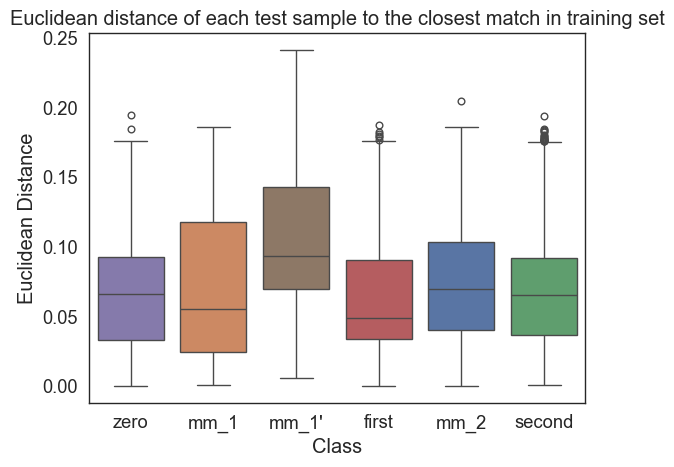

In [20]:
class_list = [
    'zero',
    'mm_1',
    'mm_1_out',
    'first',
    'mm_2',
    'second',
]

sns.boxplot(data=distances_df, order=class_list)
plt.title('Euclidean distance of each test sample to the closest match in training set')
plt.ylabel('Euclidean Distance')
plt.xlabel('Class')
tick_marks = np.arange(len(class_list))
class_list = [
    'zero',
    'mm_1',
    'mm_1\'',
    'first',
    'mm_2',
    'second',
]
plt.xticks(tick_marks, class_list)
plt.show()